# Working with imagery
This Notebook shows how to search, display, import and export imagery in the Playground.

In [1]:
# Standard imports
import os
import json
import mercantile

# Widgets imports
from ipyleaflet import Map, TileLayer, Polygon, LayersControl, basemaps, basemap_to_tiles
import ipywidgets as widgets
from IPython.core.display import HTML

## Connecting to the API

To connect to the API, you need to retrieve your API_KEYS from the OneAtlas website. Follow the simple steps below:

1. Visit this URL: https://data.api.oneatlas.airbus.com/api-keys
2. Click the **Create and API key** button
3. Enter a description for your API_KEY (e.g. Playground Keys)
4. Store the file in the same folder than this notebook and name it **api_key.txt**

Make sure to keep your **api_key.txt** safe! Do not include it in a public github repository for example :-)

The following script will then use this **api_key.txt** file to generate an ACCESS_TOKEN. We will store this ACCESS_TOKEN in HEADERS that we will send with each requests. The ACCESS_TOKEN has a timeout so we will create a function that renew the ACCESS_TOKEN when half of the timeout has expired. 

In [2]:
# Create a PlaygroundClient object
from playgroundclient import PlaygroundClient
play = PlaygroundClient()

# Logged in user
user = play.get_logged_user()
print("Logged as user: {} {}".format(user['firstname'], user['lastname']))

Logged as user: Jean-Francois Faudi


## Some useful functions

In [3]:
def print_json(parsed):
    print(json.dumps(parsed, indent=4, sort_keys=True))
    
def getBounds(coords):
    xmax = ymax = -np.Infinity
    xmin = ymin = np.Infinity
    for v in coords:
        xmax = xmax if xmax > v[0] else v[0]
        ymax = ymax if ymax > v[1] else v[1]
        xmin = xmin if xmin < v[0] else v[0]
        ymin = ymin if ymin < v[1] else v[1]
    return (xmin, ymin, xmax, ymax)


## Search for imagery

In [4]:
# Check which are the sensors that you can access
r = play.check_available_sensors()
SENSORS = r['constellation']
print(SENSORS)

MOSAIC-SPOT,Deimos-2,TerraSAR-X,SPOT,ZEPHYR,Sentinel-2,AERIAL,MOSAIC-PLEIADES,LOON,PLEIADES


In [5]:
BBOX = "2.8,42.7,2.9,42.8"
SENSORS = 'PLEIADES,SPOT'

images = play.get_images(BBOX, SENSORS)
#print_json(images)

i_database = {}
i_label = []
#print_json(images)
for image in images['features']:
    image_uid = image['id']
    i_label.append((image['properties']['constellation'] + " from " + image['properties']['acquisitionDate'][0:10], image_uid))
    i_database[image_uid] = image
    
i_label.sort() 
i_w = widgets.Dropdown(
    options=i_label,
    description='Images:',
    disabled=False
)
display(i_w)

Dropdown(description='Images:', options=(('PLEIADES from 2016-09-22', '95e878942335216e74e88a9d9e2a97156870bfc…

In [6]:
image_uid = i_w.value
r = play.get_image_from_uid(image_uid)
print_json(r)
source_id = r['features'][0]['properties']['sourceId']

{
    "error": false,
    "features": [
        {
            "geometry": {
                "coordinates": [
                    [
                        [
                            2.776185185185184,
                            42.76358333333333
                        ],
                        [
                            3.035199074074074,
                            42.76358333333333
                        ],
                        [
                            3.035199074074074,
                            42.62941666666666
                        ],
                        [
                            2.776185185185184,
                            42.62941666666666
                        ],
                        [
                            2.776185185185184,
                            42.76358333333333
                        ]
                    ]
                ],
                "orientation": "clockwise",
                "type": "Polygon"
            },
      

In [7]:
r = play.get_image_from_sourceid(source_id)
print_json(r)

{
    "error": false,
    "features": [
        {
            "geometry": {
                "coordinates": [
                    [
                        [
                            2.77612962962963,
                            42.76358333333333
                        ],
                        [
                            3.035199074074074,
                            42.76358333333333
                        ],
                        [
                            3.035199074074074,
                            42.62941666666666
                        ],
                        [
                            2.77612962962963,
                            42.62941666666666
                        ],
                        [
                            2.77612962962963,
                            42.76358333333333
                        ]
                    ]
                ],
                "orientation": "clockwise",
                "type": "Polygon"
            },
         

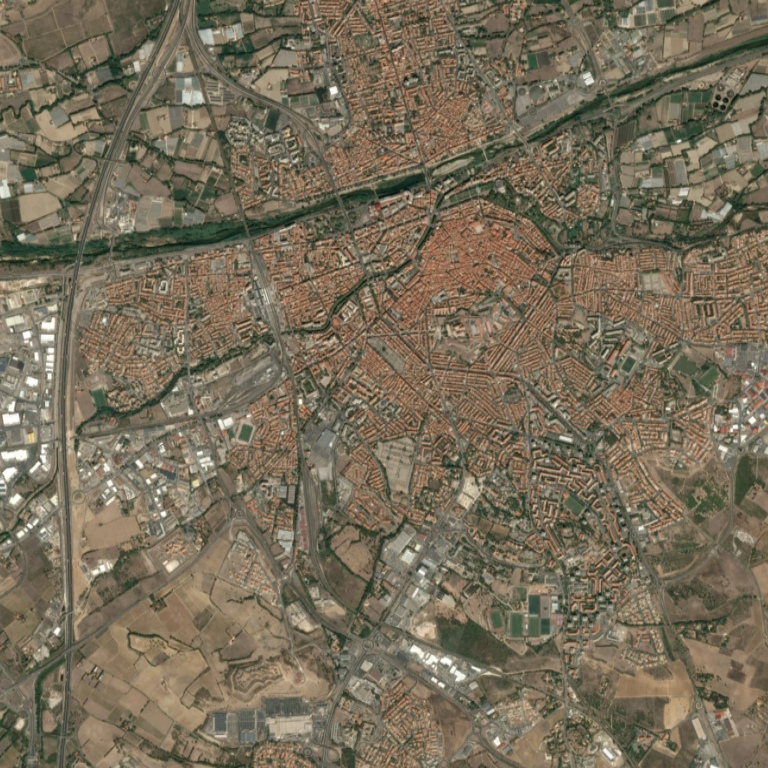

In [8]:
# These are the coords of the center of the World according to Salvador Dali
lng = 2.8791475296020512
lat = 42.69606265394371
zoom = 14

# Convert this into XYZ and extract a 1024 x 1024 pixels tile
# The get_image function creates a 768x768 pixels images and takes as input XYZ as its center tile
tile = mercantile.tile(lng, lat, zoom)
image = play.get_image(image_uid, tile.z, tile.x, tile.y)
image

In [9]:
# saving the image as a JPEG file to disk
filename = 'extracts/' + image_uid + '-' + str(tile.z) + '-' + str(tile.x) + '-' + str(tile.y)
image.save(filename + '.jpg')
print('Image saved to disk!')

Image saved to disk!


In [10]:
# saving the .JGW file as well to get coordinates
param = play.get_image_proj(tile.z, tile.x, tile.y)
with open(filename + '.jgw', 'w') as outfile:
    outfile.write(param)
    
# also write the associated .PRJ file to define the WebMercator projection in WGS84
with open(filename + '.prj', 'w') as outfile:
    outfile.write("+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs")
print('Files saved to disk!')

Files saved to disk!


In [11]:
# and you can now open this image in QGIS!